In [4]:
!pip install nilearn

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting, datasets
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Description of the dataset
HCP_DIR = "/content/drive/MyDrive/hcp_task_behavior"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}

subjects = np.loadtxt(HCP_DIR+'/subjects_list.txt',dtype='str')

In [8]:
regions = np.load(f"/content/drive/MyDrive/hcp_task_behavior/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment 
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

def load_stats(subject, experiment, run):
    task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
    for cond in EXPERIMENTS[experiment]['cond']:
        file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/Stats.txt"
        stats = pd.read_table(file,header=None,delim_whitespace=True)
        RT=np.array([stats.loc[0,3],stats.loc[1,3]])
    return RT

def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)

In [10]:
my_exp  = 'SOCIAL'

subjects_mental = []
subjects_random = []
labels_mental = []
labels_random = []
rt_mental = []
rt_random = []

for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)
    rt = load_stats(subject=s, experiment=my_exp,run=r)
    if rt[0] == -555 or rt[1] == -555:
      continue
    mental_interaction = average_frames(data, evs, my_exp, 'mental')[:80]
    random_interaction = average_frames(data, evs, my_exp, 'rnd')[:80]
    subjects_mental.append(mental_interaction)
    labels_mental.append("mental")
    rt_mental.append(rt[0])
    subjects_random.append(random_interaction)
    labels_random.append("random")
    rt_random.append(rt[1])

In [ ]:
def threshold_label(rt_array):
  labels = []
  threshold = np.median(rt_array)
  for rt in rt_array:
    if rt > threshold:
      labels.append("Slow")
    else: 
      labels.append("Fast")
  return np.array(labels)

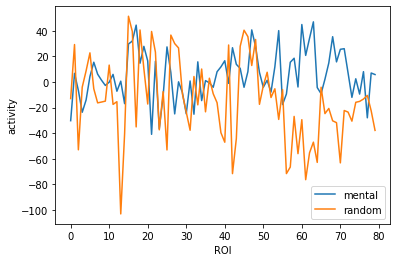

In [21]:
# Plot activity level in each ROI for both conditions
plt.plot(mental_interaction,label='mental')
plt.plot(random_interaction,label='random')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

Text(0, 0.5, 'Response Time')

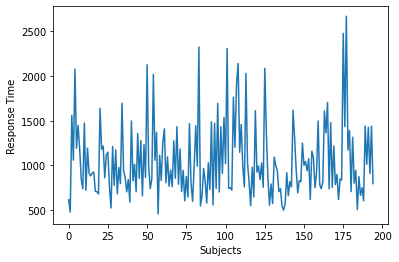

In [30]:
plt.plot(rt_mental)
plt.xlabel("Subjects")
plt.ylabel("Response Time")

Text(0, 0.5, 'Response Time')

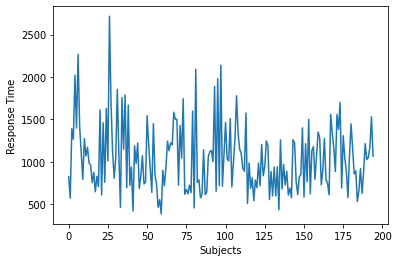

In [12]:
plt.plot(rt_random)
plt.xlabel("Subjects")
plt.ylabel("Response Time")

In [13]:
#data containing the signal for subjects responding to mental interaction condition (num_of_subjects, 360)
subjects_mental = np.array(subjects_mental)
#data containing the response time for subjects responding to mental interaction condition (num_of_subjects, 1)
rt_mental = np.array(rt_mental)
#data containing the signal for subjects responding to random interaction condition (num_of_subjects, 360)
subjects_random = np.array(subjects_random)
#data containing the response time for subjects responding to random interaction condition (num_of_subjects, 1)
rt_random = np.array(rt_random)

In [22]:
subjects_mental.shape 

(195, 80)

In [23]:
rt_mental.shape

(195,)

In [28]:
#regression model for prediction response time of mental interaction condition 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(subjects_mental, rt_mental-np.mean(rt_mental), test_size=0.2, random_state=100)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)

print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

-1.1796267872283321
402353.0934739052


In [20]:
y_pred_tr= reg.predict(X_train)
print(r2_score(y_train,y_pred_tr))
print(mean_squared_error(y_train,y_pred_tr))

0.5725375035944792
71413.81322069516


In [15]:
#regression model for prediction response time of random interaction condition
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(subjects_random, rt_random, test_size=0.2, random_state=100)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)

print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))

-1.5721310598769733
322550.81218041864
